# Generator of random plots

Random functions are generated by cubic spline interpolation with randomly selected knots:

1. Create random knots. The user specifies the number of knots. The program generates random coordinates for these knots plus two boundary knots.

2. Curves are generated by cubic spline interpolation.

3. For each curve, the program generates a grid with a random number of horizontal and vertical lines (not necessarily the same) and adds the curve to the plot. To save memory and improve speed, all plots are black and white (no shades of gray): 0 for white and 1 for black.

4. The curves and plots are saved in separate npy files.

This version uses Matplotlib to create plots which are then saved in Numpy arrays. Curve and grid line thickness could also vary from plot to plot by this version uses the Matplotlib default values.

The previous version did not use Matplotlib and produced plot arrays directly from curves but the resulting lines were dotted in areas where the curves were rising or falling rapidly.

In [1]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
dpi = 72
size_x = 3 # Horizontal size in inches
size_y = 3 # Vertical size in inches
dim_x = size_x * dpi  # Maximum value of x
dim_y = size_y * dpi # Maximum value of y
n_knots = 2 # Number of "internal" knots, i.e. knots excluding boundary knots, used in random curve generation
n_samples = 10

## Creating a 2D array with coordinates of knots

Rows are samples. The first half of columns are x coordinates of the knots; the second, ys. The x and y coordinates are in the same dimension to use the apply_along_axis function below. X coordinates are a strictly increasing sequence and include endpoints.

Function to create a set of knots for a single curve: a 1D array with knot coordinates for a given number of knots.

In [3]:
def random_knots(n_knots):
    knots_y = np.random.randint(low = 1, 
                                high = dim_y, 
                                size = (n_knots + 2),
                               dtype=np.int16)

    knots_x = np.random.choice(np.arange(1, dim_x - 2, dtype=np.int16), 
                                size = (n_knots), 
                                replace=False)
    knots_x.sort(axis=0) # Values of x need to be ordered for cubic interpolation.

    knots_all = np.concatenate(
        (np.array([0], dtype=np.int16),
         knots_x,
         np.array([dim_x - 1], dtype=np.int16),
         knots_y), 
        axis=0)
    return knots_all

Creating the knots array:

In [4]:
knots_all = np.apply_along_axis(random_knots,
                                1, 
                                np.full ((n_samples,1), 2, dtype=np.int16)
                               )

In [5]:
knots_all[0:5, :]

array([[  0,   9, 118, 215,  34,  12,  22,  54],
       [  0,  42, 109, 215, 137,  68,  72, 166],
       [  0,  83, 132, 215, 104,  37,  22, 152],
       [  0,  16, 112, 215,  50,   3,  49,  18],
       [  0, 110, 187, 215,  55,  69, 204,  78]], dtype=int16)

x coordinates of knots:

In [6]:
knots_all[0:5, 0:(n_knots+2)]

array([[  0,   9, 118, 215],
       [  0,  42, 109, 215],
       [  0,  83, 132, 215],
       [  0,  16, 112, 215],
       [  0, 110, 187, 215]], dtype=int16)

y coordinates of knots:

In [7]:
knots_all[0:5, (n_knots+2) : ((n_knots + 2) * 2)]

array([[ 34,  12,  22,  54],
       [137,  68,  72, 166],
       [104,  37,  22, 152],
       [ 50,   3,  49,  18],
       [ 55,  69, 204,  78]], dtype=int16)

## Random curves

Function generating a random curve. Its domain is [0, dim_x]. The curve is an array of size (dim_x, dim_y) generated using cubic spline interpolation for given knots.

The generated curves are compressed or stretched and shifted to make sure they fit into the plot.

### Big question

The question: should the y coordinates of the curves be stored as float values or integers representing the y coordinate in pixels. In this version, I use integer y coordinates as the neural network will only "see" pixels.

In [8]:
def random_function(knots):
    x = np.arange(dim_x)
    cs = CubicSpline(knots[0:(n_knots+2)], knots[(n_knots+2) : ((n_knots + 2) * 2)])
    y = cs(x)
    y = y - y.min() + 2 # Shifting so that ymin is just above the bottom of the plot
    y = y * (dim_y - 2) / y.max() # Scaling so that ymax is just below the top
    return np.int16(y.round())

In [9]:
curves = np.apply_along_axis(random_function, 1, knots_all)

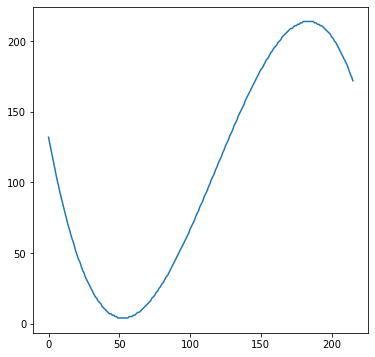

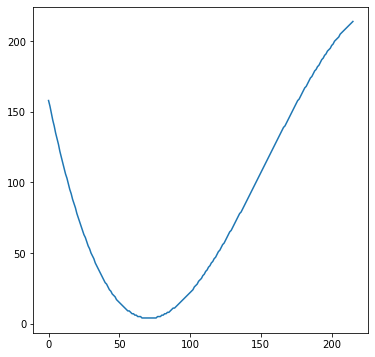

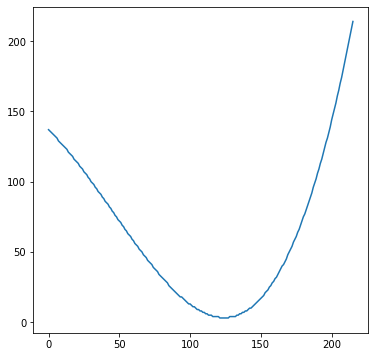

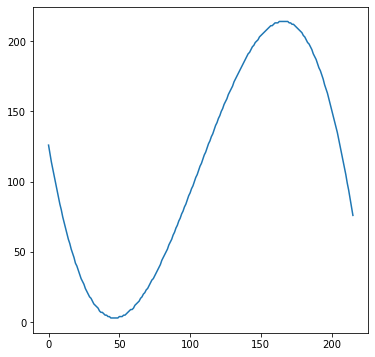

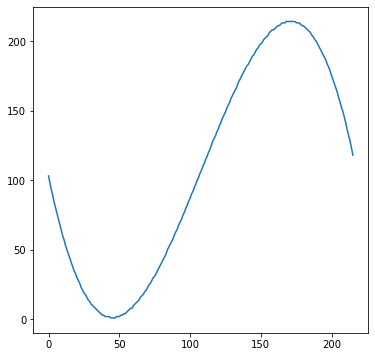

In [10]:
for n in range(5):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(np.arange(dim_x), curves[n,:])

## Random plots

Function to produce an array with random plots. Each sample is a plot of a given random curve (input variable) with a random grid. Number of grid lines along x and y is different and is selected randomly from an interval from 1 (one grid line in the center of the plot plus lines on the sides) to 8.

In [33]:
def random_plot(curve):
    ngrid_x = random.randint(1, 8)
    ngrid_y = random.randint(1, 8)
    grid_coord_x = [int(i * dim_x / (ngrid_x + 1)) - 1 for i in range(1, ngrid_x + 2)]
    grid_coord_y = [int(i * dim_y / (ngrid_y + 1)) + 1 for i in range(ngrid_y + 1)]
    fig, ax = plt.subplots(figsize=(size_x, size_y), dpi=dpi)
    x = list(range(len(curve)))
    plt.plot(x, curve, color = 'black')
    plt.yticks(grid_coord_y)
    plt.xticks(grid_coord_x)
    plt.xlim(0, dim_x)
    plt.ylim(0, dim_y)
    plt.tick_params(
        axis='both',          # changes apply to both axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    plt.grid(True)
    fig.tight_layout(pad=0)
    fig.canvas.draw()
    plot = np.ceil((1 - np.flipud(np.mean(np.array(fig.canvas.renderer.buffer_rgba()), 2)) / 255))
    plt.close(fig)
    return np.int8(plot)

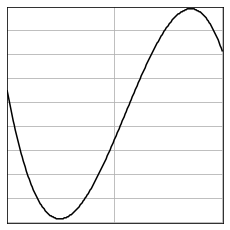

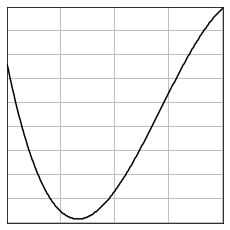

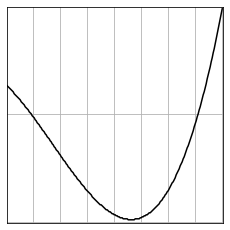

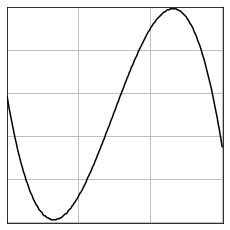

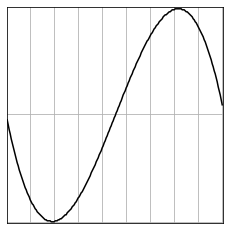

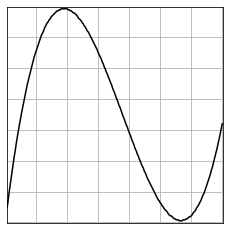

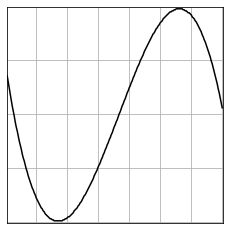

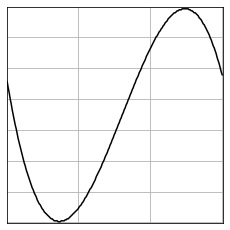

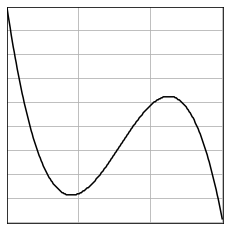

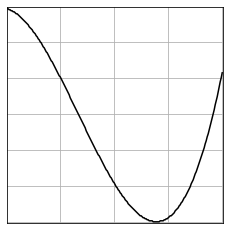

In [34]:
plots = np.apply_along_axis(random_plot, 1, curves)

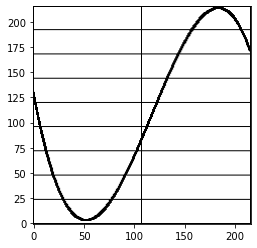

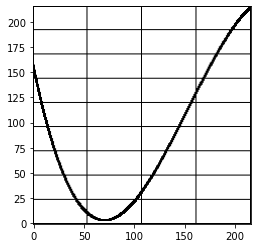

In [35]:
for n in range(2):
    plt.imshow(plots[n, :, :], cmap='gray_r', vmin=0, vmax=1, origin='lower')
    plt.show()

In [15]:
np.save('E:\MyCode\Portfolio\PlotRecognition\curves.npy', curves)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\MyCode\\Portfolio\\PlotRecognition\\curves.npy'

In [16]:
np.save('E:\MyCode\Portfolio\PlotRecognition\plots.npy', plots)